In [85]:
###This block only defines functions for creating the 2 NN's and their training 

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


###Creating a newtork with 2 hidden layers..
class Classifier(nn.Module):
    
    def __init__(self, width, n_inputs):
        super(Classifier, self).__init__()
        self.width = width
    
        # input layer
        self.input = nn.Linear(n_inputs, width)
    
        # hidden layers
        self.h1 = nn.Linear(width, width)
        self.h2 = nn.Linear(width, width)
    
        # output layer (Our NN output=1)
        self.output = nn.Linear(width, 1)
        
    def forward(self, x):
    
        # input layer
        x = F.relu(self.input(x))
    
        # hidden layers
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        
        # output layer
        x = torch.sigmoid(self.output(x))
    
        return x



###Training the NN.. Defining optimizer and learning rate..
def normal_training(generating_function, N_train):
    
    # determine the size of the classifier
    #~~~The next step is meant to only bring about the dimension of X to use it in the n_inputs line
    X, _, _ = generating_function(125)
    n_inputs = X.shape[1]
    
    #~~~Create the network containing 10 neurons per layer
    clf = Classifier(125, n_inputs=n_inputs)
    
    optimiser = torch.optim.Adam(clf.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    # track the losses
    clf_losses = []
    clf_losses_test = []

    for _ in range(N_train):

        # create the data
        #~~~X,Y,Z are numpy arrays of dimensions 512
        X, Y, Z = generating_function(512)
        #~~~Convert each of them to a torch tensor of the same dimension
        X = torch.as_tensor(X, dtype=torch.float)
        Y = torch.as_tensor(Y.reshape(-1, 1), dtype=torch.float)
        Z = torch.as_tensor(Z.reshape(-1, 1), dtype=torch.float)

        # make the training loss
        output = clf(X)
        loss = criterion(output, Y)
        clf_losses.append(loss.data.numpy().item())

        # backprop
        clf.zero_grad()
        loss.backward()
        optimiser.step()
        
        # test loss
        X_test, Y_test, _ = generating_function(512, train=False)
        X_test = torch.as_tensor(X_test, dtype=torch.float)
        Y_test = torch.as_tensor(Y_test.reshape(-1, 1), dtype=torch.float)
        output_test = clf(X_test)
        loss_test = criterion(output_test, Y_test)
        clf_losses_test.append(loss_test.data.numpy().item())
    
    print('Done with training')

    fig, ax = plt.subplots()
    ax.plot(range(len(clf_losses)), clf_losses, label='train loss')
    ax.plot(range(len(clf_losses_test)), clf_losses_test, label='test loss')
    ax.set_xlabel('Training step')
    ax.set_ylabel('Classifier loss')
    ax.legend(loc='best')
    plt.show()
    
    return clf
    
    
    
###Creating the adversarial NN..
class Regressor(nn.Module):
    
    def __init__(self, width):
        super(Regressor, self).__init__()
        self.width = width
    
        # input layer
        self.input = nn.Linear(1, width)
    
        # hidden layers
        self.h1 = nn.Linear(width, width)
        self.h2 = nn.Linear(width, width)
    
        # output layer
        self.output = nn.Linear(width, 1)

    def forward(self, x):
    
        # input layer
        x = F.relu(self.input(x))
    
        # hidden layers
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        
        # output layer
        x = self.output(x)
    
        return x



###Training the adversarial NN..
def adversarial_training(generating_function, N_train):
    
    # determine the size of the classifier
    X, _, _ = generating_function(125)
    n_inputs = X.shape[1]
    
    # create the classifier and the adversary networks
    clf = Classifier(125, n_inputs=n_inputs)
    adv = Regressor(125)

    # training settings
    learning_rate = 0.001
    lam = 0.75 # lambda tradeoff parameter (Originally=10)

    # create optimisers (larger learning rate for the adversary )
    clf_optimiser = torch.optim.Adam(clf.parameters(), lr=learning_rate)
    adv_optimiser = torch.optim.Adam(adv.parameters(), lr=5*learning_rate)

    # choose the criterions
    clf_criterion = nn.BCELoss()
    adv_criterion = nn.MSELoss()

    
    # keep track of the losses
    clf_losses = []
    adv_losses = []
    clf_losses_test = []
    adv_losses_test = []

    # training loop
    for _ in range(N_train):

        # create the data
        X, Y, Z = generating_function(512)
        X = torch.as_tensor(X, dtype=torch.float)
        Y = torch.as_tensor(Y.reshape(-1, 1), dtype=torch.float)
        Z = torch.as_tensor(Z.reshape(-1, 1), dtype=torch.float)

        ##############################
        # Update the adversary network
        # (several updates to keep up with
        # the changes in the classifier)
        ##############################
    
        M = 5
        for _ in range(M):
            # make the adversary loss
            clf_output = clf(X)
            adv_output = adv(clf_output)
            adv_loss = adv_criterion(adv_output, Z)
    
            # backprop: adapt the adversary to the classifier (only update the adversary weights)
            adv.zero_grad()
            adv_loss.backward()
            adv_optimiser.step()
            
        adv_losses.append(adv_loss.data.numpy().item())

        ##############################
        # Update the classifier network
        ##############################
    
        # forward pass
        clf_output = clf(X)
        adv_output = adv(clf_output)
    
        # make the losses: both the classifier and the adversary loss
        # combined loss: note the minus sign!
        # (when updating the classifier, the goal is to confuse the adversary)
        clf_loss = clf_criterion(clf_output, Y)
        adv_loss = adv_criterion(adv_output, Z)
        comb_loss = clf_loss - lam * adv_loss
            
        # backprop the classifier: update only the classifier weights (keep adversary intact)
        clf.zero_grad()
        comb_loss.backward()
        clf_optimiser.step()
            
        clf_losses.append(clf_loss.data.numpy().item())
    
        #######################
        # store the test losses
        #######################
        X_test, Y_test, _ = generating_function(512, train=False)
        X_test = torch.as_tensor(X_test, dtype=torch.float)
        Y_test = torch.as_tensor(Y_test.reshape(-1, 1), dtype=torch.float)
        output_test = clf(X_test)
        loss_test = clf_criterion(output_test, Y_test)
        clf_losses_test.append(loss_test.data.numpy().item())
    
    print('Done with training')

    fig, ax = plt.subplots(2, sharex=True)
    ax[0].plot(range(len(clf_losses)), clf_losses, label='train loss')
    ax[0].plot(range(len(clf_losses_test)), clf_losses_test, label='test loss')
    ax[0].set_ylabel('Classifier loss')
    ax[0].legend(loc='best')
    ax[1].plot(range(len(adv_losses)), adv_losses, color='k')
    ax[1].set_ylabel('Adversary loss')
    ax[1].set_xlabel('Training step')
    plt.show()
    
    return clf



In [45]:
###This block is dedicated to creating plots to evaluate the training of the NN

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve


def show_roc_curves(ax, clf, generate):    
    
    X0, Y0, Z0 = generate(10000, 0, 1)
    Y0_pred = clf(torch.as_tensor(X0, dtype=torch.float))
    
    X1, Y1, Z1 = generate(10000, 1, 3.14)
    Y1_pred = clf(torch.as_tensor(X0, dtype=torch.float))
    

    # compute the roc curves
    Y0_pred = clf(torch.as_tensor(X0, dtype=torch.float))
    fpr0, tpr0, _ = roc_curve(Y0, Y0_pred.data)
    roc_auc0 = metrics.auc(fpr0, tpr0)

    Y1_pred = clf(torch.as_tensor(X1, dtype=torch.float))
    fpr1, tpr1, _ = roc_curve(Y1, Y1_pred.data)
    roc_auc1 = metrics.auc(fpr1, tpr1)


    # draw the roc curves
    ax.plot(fpr0, tpr0, c='k', label='0 <dPhi< 1,   AUC = %0.2f' % roc_auc0)
    ax.plot(fpr1, tpr1, c='red', label='1 <dPhi < 3.14,   AUC = %0.2f' % roc_auc1)

    # cosmetics
    ax.legend(loc='best')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('ROC curve')
    
    
def show_clf_output(ax, clf, generate):

    # generate test data
    n_samples = 10000
    X0, Y0, Z0 = generate(n_samples, 0, 1)
    X1, Y1, Z1 = generate(n_samples, 1, 3.14)
    

    # compute the predictions
    Y0_pred = clf(torch.as_tensor(X0, dtype=torch.float)) 
    Y1_pred = clf(torch.as_tensor(X1, dtype=torch.float))
   
    # show them
    bins = 30
    ax.hist(Y0_pred.data.numpy(), bins=bins, density=True, color='k', histtype='step', label='0 <dPhi< 1 ')
    ax.hist(Y1_pred.data.numpy(), bins=bins, density=True, color='red', histtype='step', label='1 <dPhi< 3.14')
   
    
    ax.set_yscale('log')

    # cosmetics
    ax.legend(loc='best')
    ax.set_title('Classifier output')
    ax.set_xlabel('Classifier output')
    
    
def evaluate_hbb_classifier(clf):

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    show_roc_curves(ax[0], clf, test1)
    show_clf_output(ax[1], clf, test1)
    plt.show()
    

In [3]:
## Function that generates n_samples of Training data

def generate_hbb(n_samples, train=True):
    
    # test or train
    X_full = X_train if train else X_test
    Y_full = Y_train if train else Y_test
    Z_full = Z_train if train else Z_test

    # sample the events
    random_state = np.random.randint(0, 10000)
    X = X_full.sample(n_samples, random_state=random_state)
    Y = Y_full.sample(n_samples, random_state=random_state)
    Z = Z_full.sample(n_samples, random_state=random_state)
    
    return X.values, Y.values, Z.values


In [4]:
## Function that generates n_samples of Training data in a range

def generating(n_samples, zmin , zmax , train=True):
    
    # test or train
    X_full = X_train if train else X_test
    Y_full = Y_train if train else Y_test
    Z_full = Z_train if train else Z_test

    
    # Concatenate all --> remove rows of dPhi out of range --> Deconcatenate
    s=pd.concat([X_train, Y_train], axis = 1)
    
    # Keep only rows which satisfy these conditions
    ss=s[(s.dPhi > zmin) & (s.dPhi < zmax)]
    
    # Deconcatenate s
    Y_full=ss.loc[:, ['Y']]          
    X_full=ss.drop(['Y'], axis=1)    ## Just drop the Y column i added
    Z_full=ss.loc[:, ['dPhi']]

  
    random_state = np.random.randint(0, 10000)
    X = X_full.sample(n_samples, random_state=random_state)
    Y = Y_full.sample(n_samples, random_state=random_state)
    Z = Z_full.sample(n_samples, random_state=random_state)
            
    return X.values, Y.values, Z.values
    

In [5]:
## Function that generates n_samples of Background Training data in a range

def generatingBg(n_samples, zmin , zmax , train=True):
    
    # test or train
    X_full = X_train if train else X_test
    Y_full = Y_train if train else Y_test
    Z_full = Z_train if train else Z_test

    
    #Concatenate all --> try to remove rows of dPhi out of range --> Deconcatenate
    s=pd.concat([X_train, Y_train], axis = 1)
    
    # Keep only rows which satisfy these conditions
    ss=s[(s.dPhi > zmin) & (s.dPhi < zmax)]
    sss=ss[(ss.Y==0)]
    
    #Deconcatenate s
    Y_full=sss.loc[:, ['Y']]          
    X_full=sss.drop(['Y'], axis=1)    ## Just drop the Y column i added
    Z_full=sss.loc[:, ['dPhi']]
  
    random_state = np.random.randint(0, 10000)
    X = X_full.sample(n_samples, random_state=random_state)
    Y = Y_full.sample(n_samples, random_state=random_state)
    Z = Z_full.sample(n_samples, random_state=random_state)
            
    return X.values, Y.values, Z.values

In [6]:
## Function that returns n_samples of Background Test data + an extra array containing the Finalweight

def generatingFW(n_samples, zmin , zmax , train=True):
    
    S_full = S_test
    P_full = Y_test
    Q_full = Z_test

    
    #Concatenate all --> try to remove rows of dPhi out of range --> Deconcatenate
    s=pd.concat([S_test, Y_test], axis = 1)
    
    # Keep only rows which satisfy these conditions
    ss=s[(s.dPhi > zmin) & (s.dPhi < zmax)]
    sss=ss[(ss.Y==0)]
    
    #Deconcatenate s
    FW_full=sss.loc[:,['Finalweight']]
    
    P_full=sss.loc[:, ['Y']]          
    S_still=sss.drop(['Y'], axis=1)    ## Just drop the Y column i added
    S_full=S_still.drop(['Finalweight'], axis=1)    ## Just drop the Finalweight column
    Q_full=sss.loc[:, ['dPhi']]
        
    random_state = np.random.randint(0, 10000)
    S = S_full.sample(n_samples, random_state=random_state)
    P = P_full.sample(n_samples, random_state=random_state)
    Q = Q_full.sample(n_samples, random_state=random_state)
    FW=FW_full.sample(n_samples, random_state=random_state)
            
    return S.values, P.values, Q.values, FW.values



In [44]:
## Function that returns all Test data X,Y,Z in a range

def test1(num, zmin, zmax):
    
    #Concatenate all --> try to remove rows of dPhi out of range --> Deconcatenate
    s=pd.concat([X_test, Y_test], axis = 1)
    
    # Keep only rows which satisfy these conditions
    ss=s[(s.dPhi > zmin) & (s.dPhi < zmax)]
    
    #Deconcatenate s
    Z_full=ss.loc[:,['dPhi']]
    
    Y_full=ss.loc[:, ['Y']]          
    X_full=ss.drop(['Y'], axis=1)    ## Just drop the Y column i added
            
    return X_full.values, Y_full.values, Z_full.values

In [7]:
# Function that returns 4 arrays~ 3 which are ALL of the Background Test data of X,Y,Z + 1 extra array of Finalweight

def test():
    
    s=pd.concat([S_test, Y_test], axis = 1)
    
    # Keep only rows which satisfy these conditions
    ss=s[(s.Y==0)]
    
    #Deconcatenate s
    FW=ss.loc[:,['Finalweight']]
    
    P=ss.loc[:, ['Y']]          
    
    S_still=ss.drop(['Y'], axis=1)    ## Just drop the Y column i added when concatenating
    S=S_still.drop(['Finalweight'], axis=1)    ## Just drop the Finalweight column
    
    Q=ss.loc[:, ['dPhi']]
    
    
    return S.values, P.values, Q.values, FW.values

Done with training


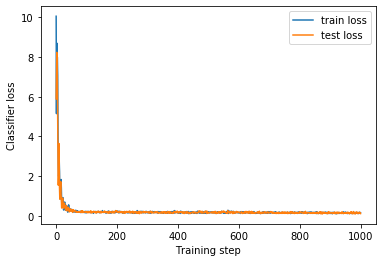

In [95]:

###Evaluating the training of the normal NN

clf_hbb = normal_training(generate_hbb, 1000)



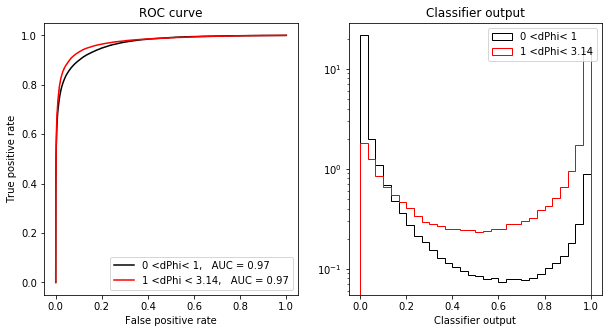

In [96]:

###Drawing plots to evaluate the effeciency of the normal NN

evaluate_hbb_classifier(clf_hbb)


In [94]:
###Import the data + split them into train/test

import os
import pandas as pd
from sklearn.model_selection import train_test_split


# prepare the data for background and signal
bg = pd.read_csv('/nfs/dust/cms/user/amohamed/susy-desy/CMGSamples/FR_forMVA_nosplit_resTop/csvs/MultiClass_background.csv')
sg = pd.read_csv('/nfs/dust/cms/user/amohamed/susy-desy/CMGSamples/FR_forMVA_nosplit_resTop/csvs/MultiClass_signal.csv')

#Add an extra column to both datasets with 0's for background and 1's for signal... Give it label Y 
bg['Y'] = 0
sg['Y'] = 1

#Concatenate bg+sg onto 1 df
sum = [bg, sg]
df = pd.concat(sum)

# (1) For now we removed the mGo and mLSP because they contained NaN
# (2) I add "Finalweight" but then remove it for the training of X
features = ['MET', 'MT', 'Jet2_pt','Jet1_pt', 'nLep', 'Lep_pt', 'Selected', 'nVeto', 'LT', 'HT', 'nBCleaned_TOTAL','nTop_Total_Combined', 'nJets30Clean', 'dPhi',"Lep_relIso","Lep_miniIso","iso_pt","iso_MT2", "Finalweight"]
S = df[features]

X = df[features].drop(['Finalweight'], axis=1)
Y = df[['Y']]
Z = df[['dPhi']]

# split
S_train, S_test, Y_train, Y_test, Z_train, Z_test = train_test_split(S, Y, Z)

#Removing Finalweight
X_train=S_train.drop(['Finalweight'], axis=1)
X_test=S_test.drop(['Finalweight'], axis=1)


Done with training


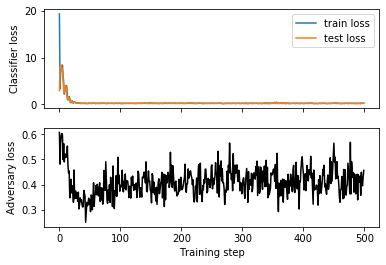

Time elapsed: 1.8473486383756001 min


In [91]:
###Evaluating the training of the adversarial NN

import time

start = time.time()

clf_hbb_adv = adversarial_training(generate_hbb, 500)

end = time.time()

elapsed = end - start

print("Time elapsed:", elapsed/60, "min")




In [92]:
# Calculating the ratio

X0, Y0, Z0, FW0 = test()
Y0_pred = clf_hbb_adv(torch.as_tensor(X0, dtype=torch.float))   ####This is the classifier output
    

A=np.zeros((Y0.size,1))
for i in range (0,Y0.size):
    A[i]=Y0_pred[i].item()     
        
dl=0; ul=0; dr=0; ur=0

for i in range(Y0.size):
    if (A[i]<0.5 and Z0[i]<1.57):
        dl=dl+1*FW0[i]
                    
    if (A[i]>0.5 and Z0[i]<1.57):
        dr=dr+1*FW0[i]          
                                
    if (A[i]<0.5 and Z0[i]>1.57):
        ul=ul+1*FW0[i]
    
    if (A[i]>0.5 and Z0[i]>1.57):
        ur=ur+1*FW0[i]
    
print("*Adversarial Classifier Output*")
print("A =", dl)
print("D =", ul)
print("B =", dr)
print("C =", ur)

print("A/D / B/C =", (dl/ul)/(dr/ur))

*Adversarial Classifier Output*
A = [3.07267135]
D = [0.08303112]
B = [0.02195747]
C = [0.00084177]
A/D / B/C = [1.41868603]


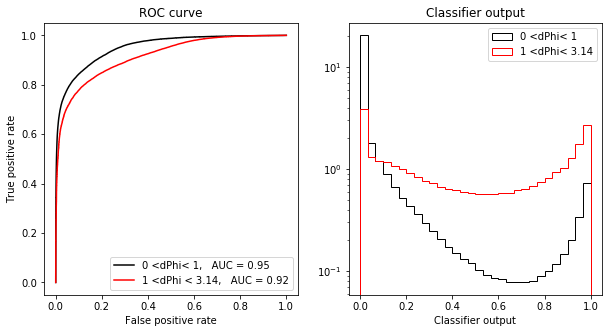

In [93]:

###Drawing plots to evaluate the effeciency of the adversarial NN

evaluate_hbb_classifier(clf_hbb_adv)


<Figure size 432x288 with 0 Axes>

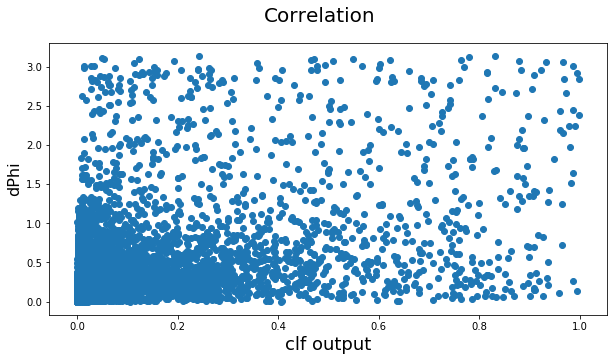

In [199]:
   ###Use "generatingFW" for the correlation graph to be able to deduce the ratios
    ## Note: it only uses background events as intended
    
    
num=10000 ###Number of points/inputs generated/to be plotted

X0, Y0, Z0, FW0 = generatingFW(num, 0, 3.14)
Y0_pred = clf_hbb(torch.as_tensor(X0, dtype=torch.float))   ####This is the classifier output
    

C=np.zeros((num,1))
for i in range (0,num):
    C[i]=Y0_pred[i].item()     
        
fig = plt.figure()
fig, ax = plt.subplots(1, figsize=(10, 5))
plt.scatter(C,Z0)
fig.suptitle('Correlation', fontsize=20)

plt.xlabel('clf output', fontsize=18)
plt.ylabel('dPhi', fontsize=16)
plt.show()


<Figure size 432x288 with 0 Axes>

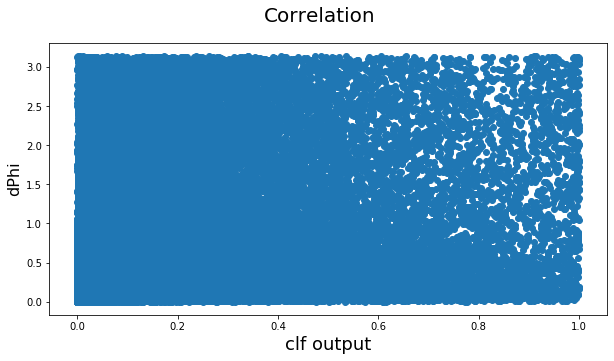

In [20]:

X0, Y0, Z0, FW0 = test()
Y0_pred = clf_hbb(torch.as_tensor(X0, dtype=torch.float))   ####This is the classifier output
    

C=np.zeros((Y0.size,1))
for i in range (0,Y0.size):
    C[i]=Y0_pred[i].item()     
        
fig = plt.figure()
fig, ax = plt.subplots(1, figsize=(10, 5))
plt.scatter(C,Z0)
fig.suptitle('Correlation', fontsize=20)

plt.xlabel('clf output', fontsize=18)
plt.ylabel('dPhi', fontsize=16)
plt.show()

In [21]:
# Deducing ratios

dl=0; ul=0; dr=0; ur=0

for i in range(Y0.size):
    if (C[i]<0.5 and Z0[i]<1.57):
        dl=dl+1*FW0[i]
                    
    if (C[i]>0.5 and Z0[i]<1.57):
        dr=dr+1*FW0[i]          
                                
    if (C[i]<0.5 and Z0[i]>1.57):
        ul=ul+1*FW0[i]
    
    if (C[i]>0.5 and Z0[i]>1.57):
        ur=ur+1*FW0[i]
    
print("*Normal Classifier Output*")  
print("A =", dl)
print("D =", ul)
print("B =", dr)
print("C =", ur)

print("A/D / B/C =", (dl/ul)/(dr/ur))

*Normal Classifier Output*
A = [3.06665909]
D = [0.0731659]
B = [0.02638275]
C = [0.01123554]
A/D / B/C = [17.84969135]


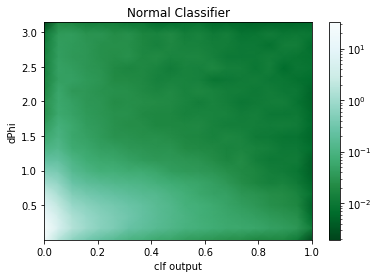

In [204]:
from scipy.stats import kde
import matplotlib.colors as colors

dataC=np.column_stack((C,Z0))
nbins = 20

k = kde.gaussian_kde(dataC.T)
xi, yi = np.mgrid[C.min():C.max():nbins*1j, Z0.min():Z0.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

plt.title('Normal Classifier')
plt.xlabel("clf output")
plt.ylabel("dPhi")
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r,norm=colors.LogNorm(vmin= zi.reshape(xi.shape).min(), vmax= zi.reshape(xi.shape).max()))
plt.colorbar()
plt.show()

<Figure size 432x288 with 0 Axes>

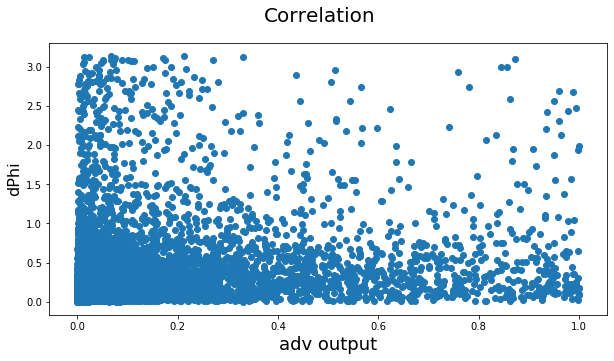

In [205]:
#Adversarial Correlation Plot

num=10000

X0, Y0, Z0, FW0 = generatingFW(num, 0, 3.14, False)
Y0_pred = clf_hbb_adv(torch.as_tensor(X0, dtype=torch.float))   ####This is the classifier output

A=np.zeros((num,1))
for i in range (0,num):
    A[i]=Y0_pred[i].item()     
        
fig = plt.figure()
fig, ax = plt.subplots(1, figsize=(10, 5))
plt.scatter(A,Z0)
fig.suptitle('Correlation', fontsize=20)

plt.xlabel('adv output', fontsize=18)
plt.ylabel('dPhi', fontsize=16)
plt.show()


<Figure size 432x288 with 0 Axes>

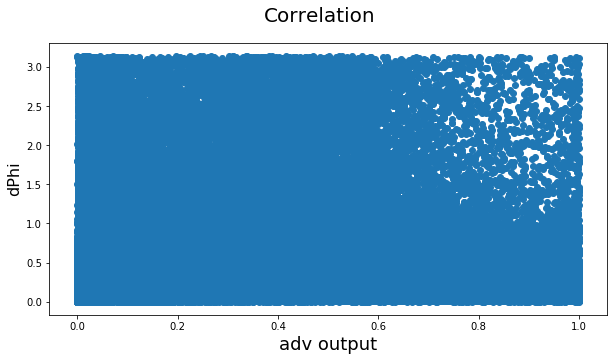

In [67]:
X0, Y0, Z0, FW0 = test()
Y0_pred = clf_hbb_adv(torch.as_tensor(X0, dtype=torch.float))   ####This is the classifier output
    

A=np.zeros((Y0.size,1))
for i in range (0,Y0.size):
    A[i]=Y0_pred[i].item()     
        
fig = plt.figure()
fig, ax = plt.subplots(1, figsize=(10, 5))
plt.scatter(A,Z0)
fig.suptitle('Correlation', fontsize=20)

plt.xlabel('adv output', fontsize=18)
plt.ylabel('dPhi', fontsize=16)
plt.show()

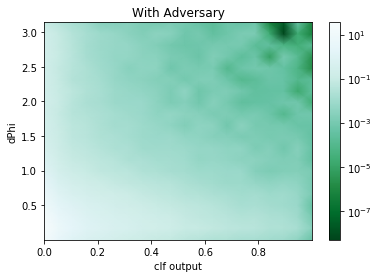

In [247]:
dataA=np.column_stack((A,Z0))

k = kde.gaussian_kde(dataA.T)
xi, yi = np.mgrid[A.min():A.max():nbins*1j, Z0.min():Z0.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

plt.title('With Adversary')
plt.xlabel("clf output")
plt.ylabel("dPhi")
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r,norm=colors.LogNorm(vmin= zi.reshape(xi.shape).min(), vmax= zi.reshape(xi.shape).max()))
plt.colorbar()
plt.show()

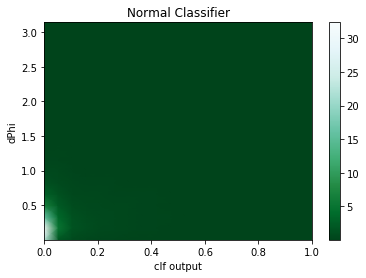

In [210]:
## Not Logarithmic

dataC=np.column_stack((C,Z0))
nbins = 20

k = kde.gaussian_kde(dataC.T)
xi, yi = np.mgrid[C.min():C.max():nbins*1j, Z0.min():Z0.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

plt.title('Normal Classifier')
plt.xlabel("clf output")
plt.ylabel("dPhi")
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
plt.colorbar()
plt.show()